# Notebook 02: Predistribution vs. Redistribution

## Does Europe achieve equality through market income or welfare state redistribution?

The conventional story says Europe is more equal because European governments
tax and transfer more aggressively. But **Blanchet, Chancel & Gethin (2022)**
argue that the key driver is actually **predistribution** — Europe's labor
markets, wage-setting institutions, and education systems produce more equal
pre-tax incomes in the first place.

### The debate

**Blanchet et al. (AEJ: Applied, 2022):** "The US actually redistributes
a greater share of national income to low-income groups than any individual
European country." Europe's lower inequality comes primarily from more equal
market incomes, not from redistribution.

**Bruenig (People's Policy Project, 2022) critique:** Blanchet et al. classify
social insurance (unemployment benefits, pensions, disability payments) as
pre-tax income rather than redistribution. This effectively "defines the welfare
state out of existence" — since those programs ARE the European welfare state.

### The underlying conceptual issue

Where you draw the line between "market" and "state" determines the answer.
If publicly-mandated social insurance is market income (because it's
contribution-based), then Europe achieves equality through markets. If it's
redistribution (because it's tax-funded and state-mandated), then the welfare
state does the work.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from data.config import FOCUS_COUNTRIES, EXTENDED_COUNTRIES, COUNTRY_NAMES
from data.plotting import (set_style, country_color, country_name,
                           slope_chart, save_figure, annotate_countries)
from data import swiid, wid

set_style()

***
## 1. Slope Chart: Market Gini → Disposable Gini

Each line connects a country's **market income Gini** (left) to its
**disposable income Gini** (right). Steeper slopes = more redistribution.

Notice that Nordic countries have moderate market inequality but steep slopes
(heavy redistribution), while Anglo-Saxon countries have high market inequality
and shallower slopes.

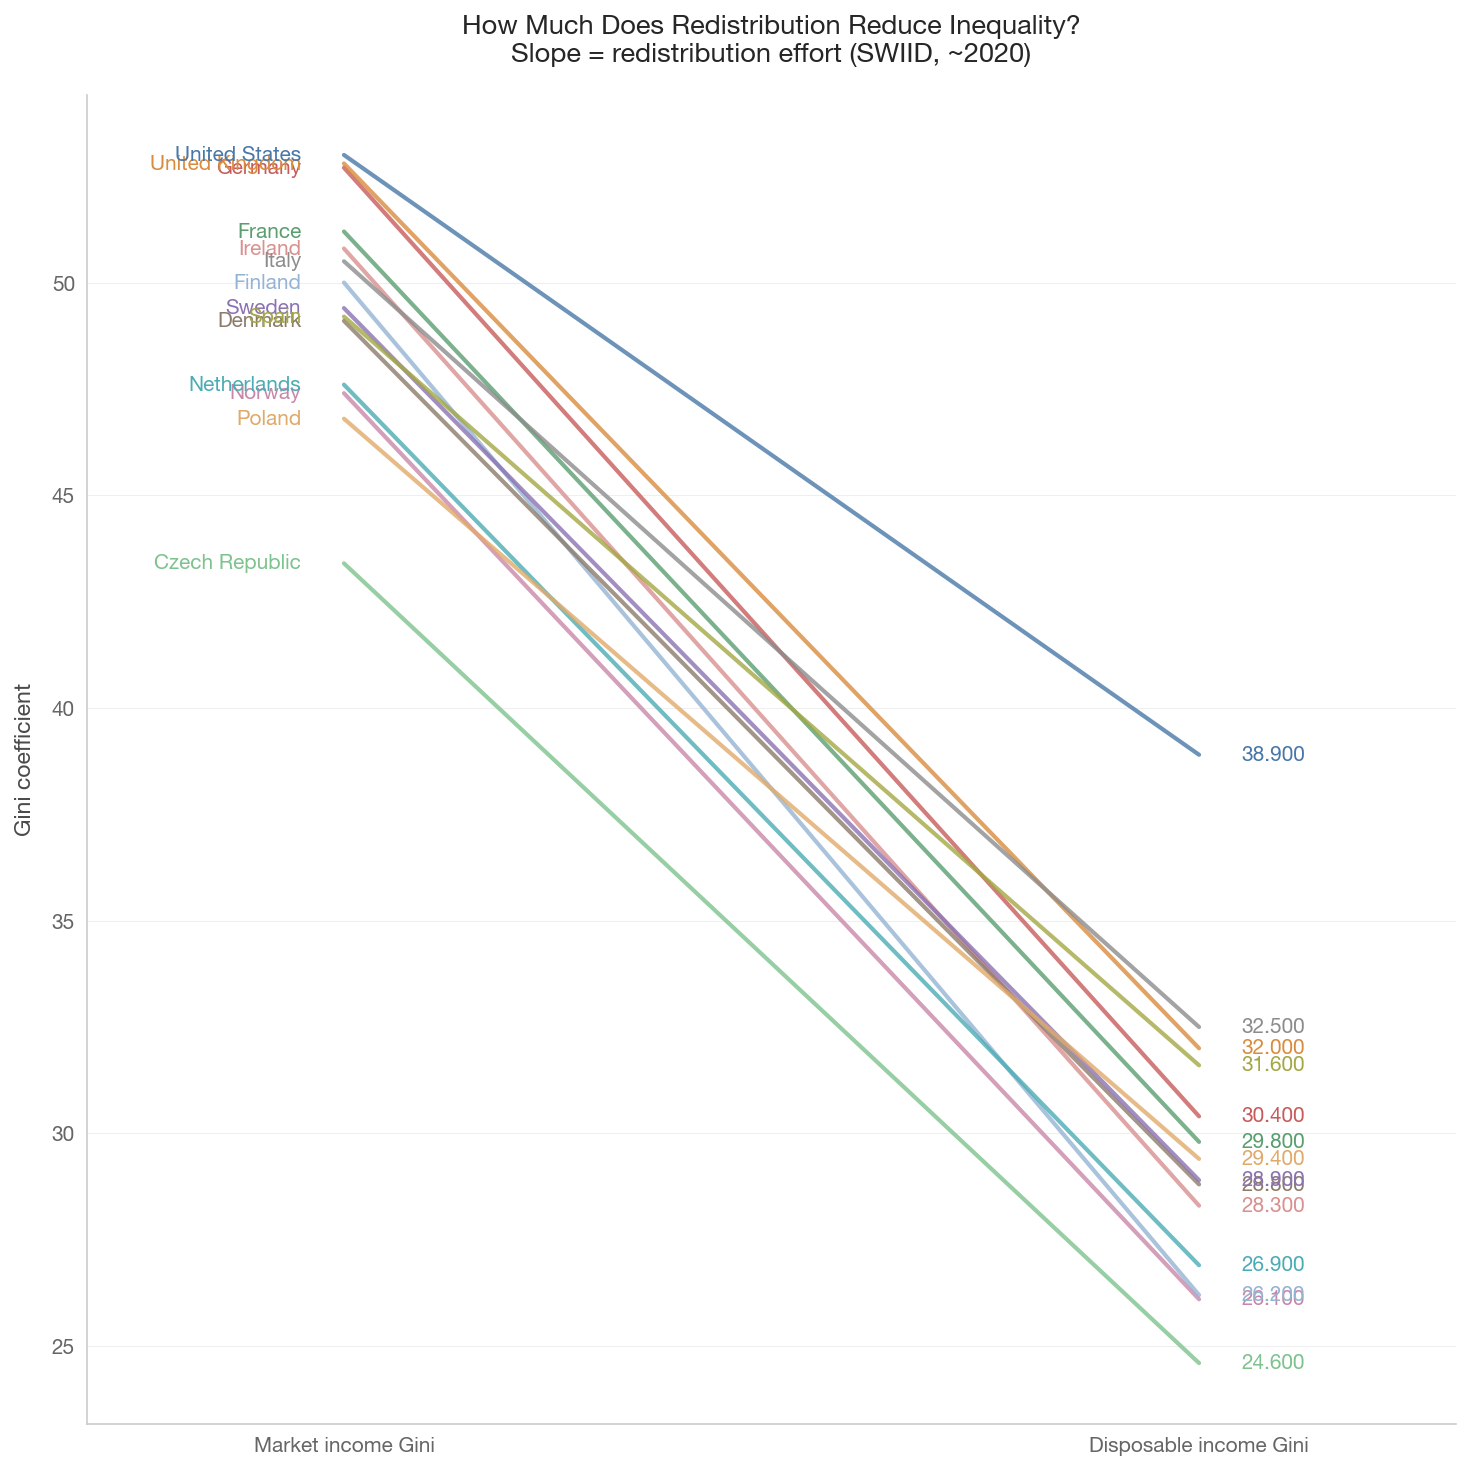

In [2]:
redist = swiid.get_redistribution(EXTENDED_COUNTRIES,
                                   start_year=2017, end_year=2022)

if not redist.empty:
    # Take most recent year per country
    latest = (redist.sort_values('year', ascending=False)
              .groupby('country_code').first().reset_index())
    latest = latest.dropna(subset=['gini_mkt', 'gini_disp'])
    latest = latest[latest['country_code'] != '']  # Remove unmapped
    latest = latest.sort_values('gini_disp')  # Sort by final inequality
    
    fig, ax = plt.subplots(figsize=(10, 10))
    slope_chart(ax,
                latest['gini_mkt'].values,
                latest['gini_disp'].values,
                latest['country_code'].values,
                left_label='Market income Gini',
                right_label='Disposable income Gini')
    
    ax.set_title('How Much Does Redistribution Reduce Inequality?\n'
                 'Slope = redistribution effort (SWIID, ~2020)', fontsize=13)
    plt.tight_layout()
    save_figure(fig, '02_slope_chart_redistribution')
    plt.show()
else:
    print("SWIID redistribution data not available.")

***
## 2. Redistribution Scatter: Pre-tax Inequality vs. Redistribution Magnitude

x-axis: How unequal is the market income distribution?
y-axis: How much does the tax-transfer system reduce inequality?

The US sits in a distinctive position: high pre-tax inequality, moderate redistribution.

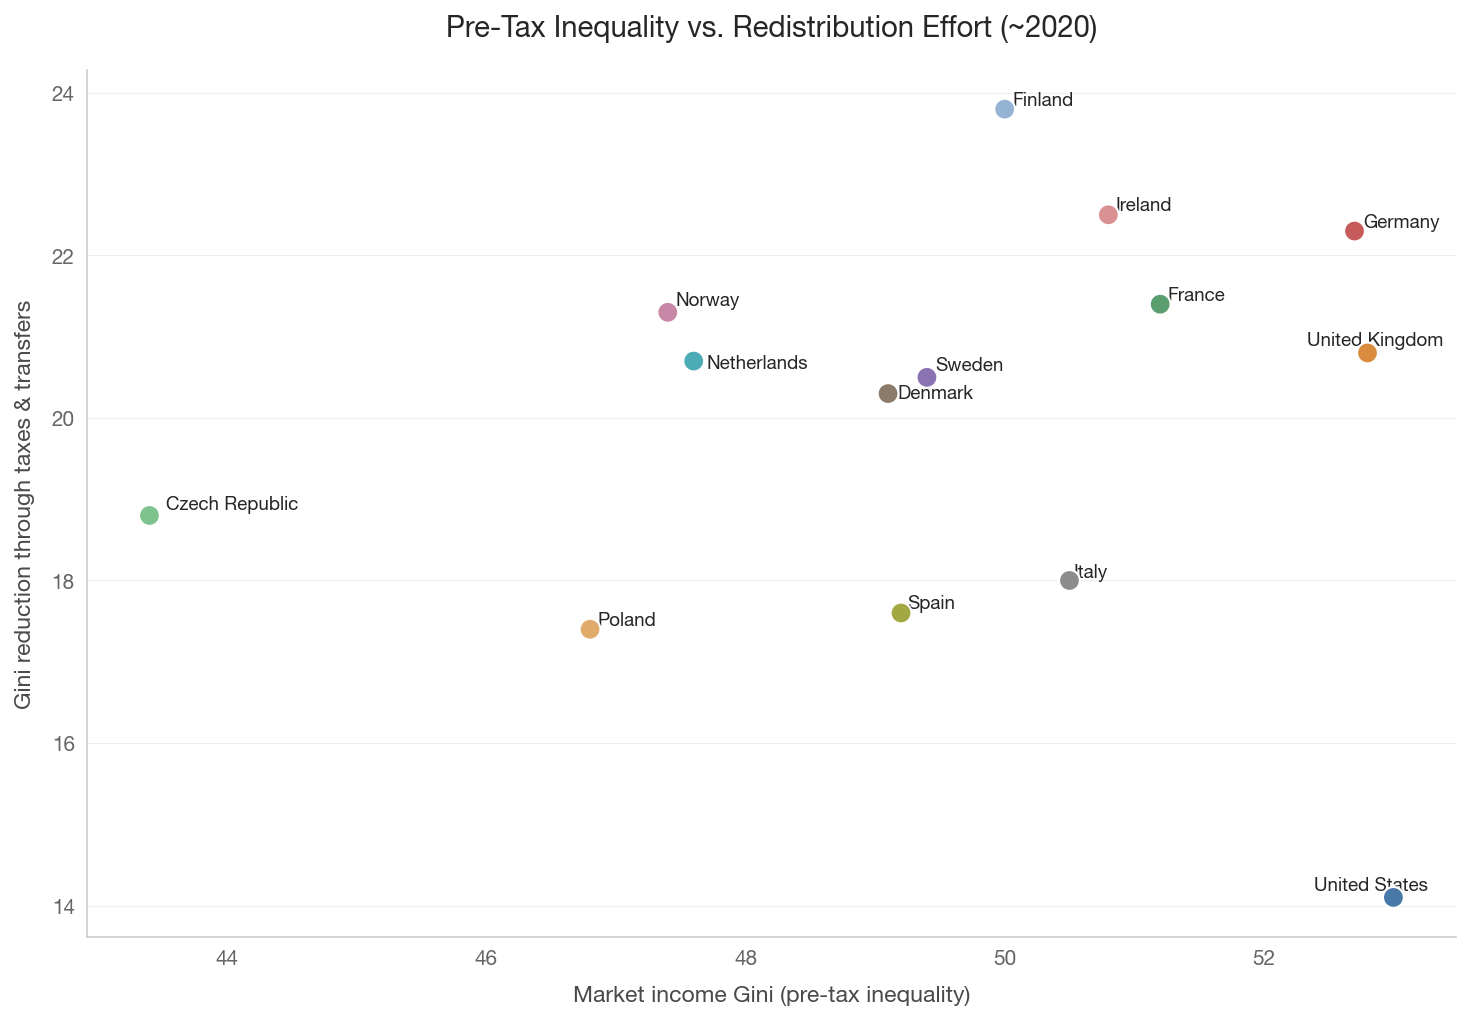

In [3]:
if not redist.empty:
    latest = (redist.sort_values('year', ascending=False)
              .groupby('country_code').first().reset_index())
    latest = latest.dropna(subset=['gini_mkt', 'gini_disp'])
    latest = latest[latest['country_code'] != '']
    latest['abs_reduction'] = latest['gini_mkt'] - latest['gini_disp']
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    colors = [country_color(c) for c in latest['country_code']]
    ax.scatter(latest['gini_mkt'], latest['abs_reduction'],
               c=colors, s=100, zorder=5, edgecolors='white', linewidth=1)
    
    annotate_countries(ax, latest['gini_mkt'].values,
                       latest['abs_reduction'].values,
                       latest['country_code'].values)
    
    ax.set_xlabel('Market income Gini (pre-tax inequality)')
    ax.set_ylabel('Gini reduction through taxes & transfers')
    ax.set_title('Pre-Tax Inequality vs. Redistribution Effort (~2020)', fontsize=14)
    
    plt.tight_layout()
    save_figure(fig, '02_redistribution_scatter')
    plt.show()
else:
    print("SWIID data not available.")

***
## 3. Pre-Tax Top 10% Share: The Divergence Since 1980

Before taxes and transfers, how much of national income goes to the top 10%?
The US and Europe diverged sharply starting around 1980 — the US top 10%
share soared while European shares remained relatively stable.

This divergence in **predistribution** is the phenomenon Blanchet et al. argue
is the primary driver of the US-Europe inequality gap.

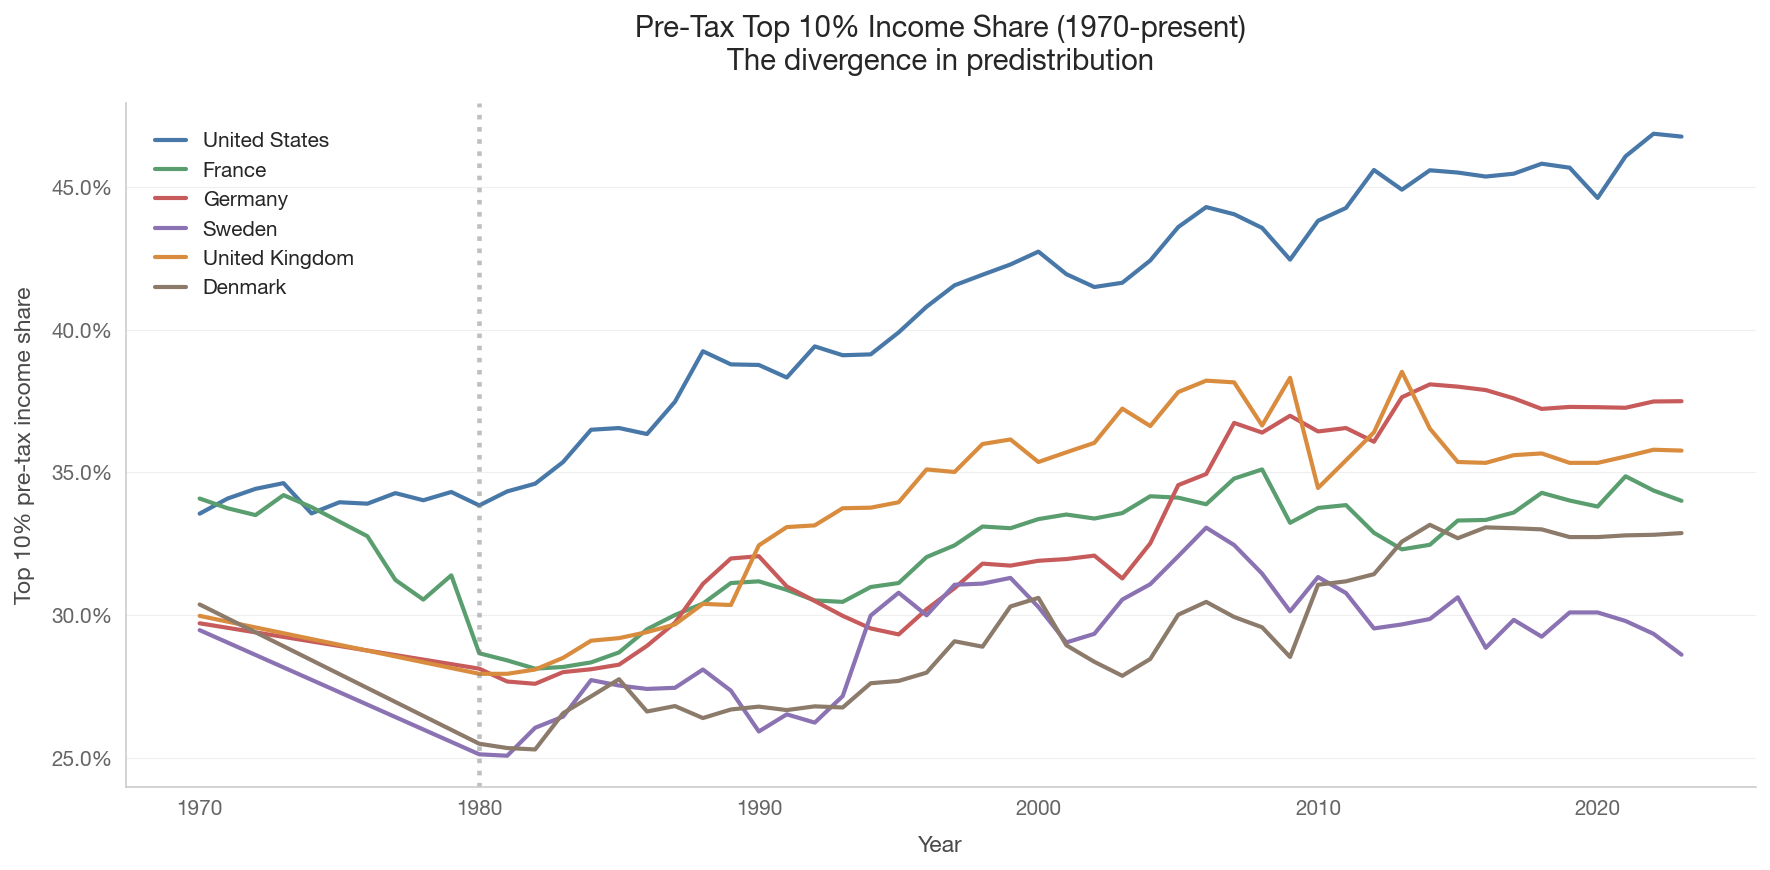

In [4]:
ts_countries = ['US', 'FR', 'DE', 'SE', 'GB', 'DK']

# Pre-tax top 10% share
pretax_top10 = wid.get_top_shares_timeseries(
    ts_countries, percentile='p90p100', concept='pretax', start_year=1970
)

if not pretax_top10.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for cc in ts_countries:
        data = pretax_top10[pretax_top10['country'] == cc].sort_values('year')
        if not data.empty:
            ax.plot(data['year'], data['value'],
                    color=country_color(cc), linewidth=2,
                    label=country_name(cc))
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_xlabel('Year')
    ax.set_ylabel('Top 10% pre-tax income share')
    ax.set_title('Pre-Tax Top 10% Income Share (1970-present)\n'
                 'The divergence in predistribution', fontsize=14)
    ax.legend()
    ax.axvline(x=1980, color='gray', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    save_figure(fig, '02_pretax_top10_timeseries')
    plt.show()
else:
    print("WID data not available.")

***
## 4. Bottom 50% Share: Pre-Tax vs. Post-Tax

The bottom 50%'s share of national income shows the flip side.
How much of the pie goes to the poorer half of the population,
before and after the tax-transfer system intervenes?

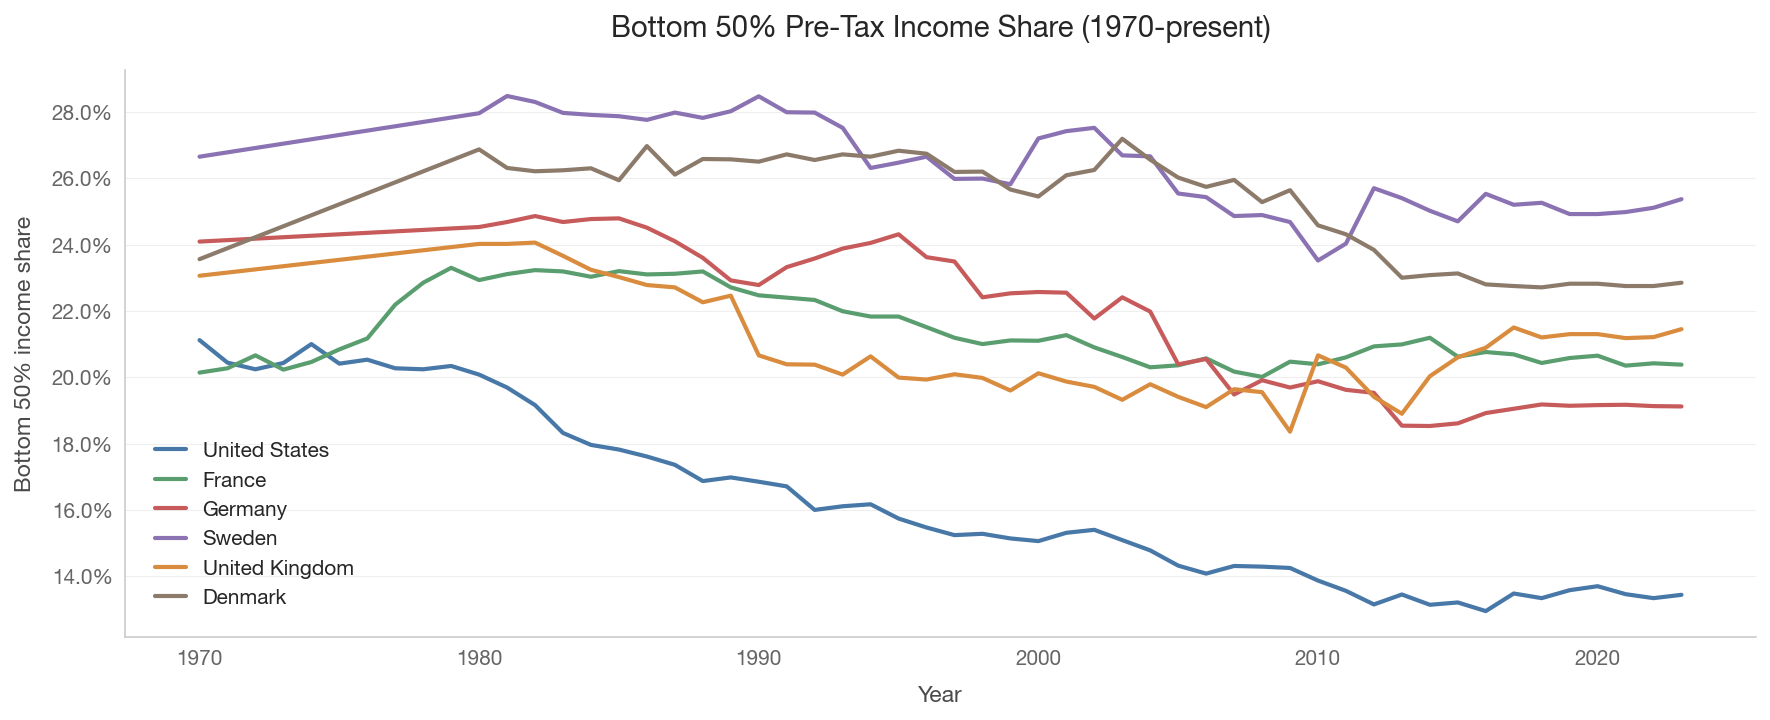

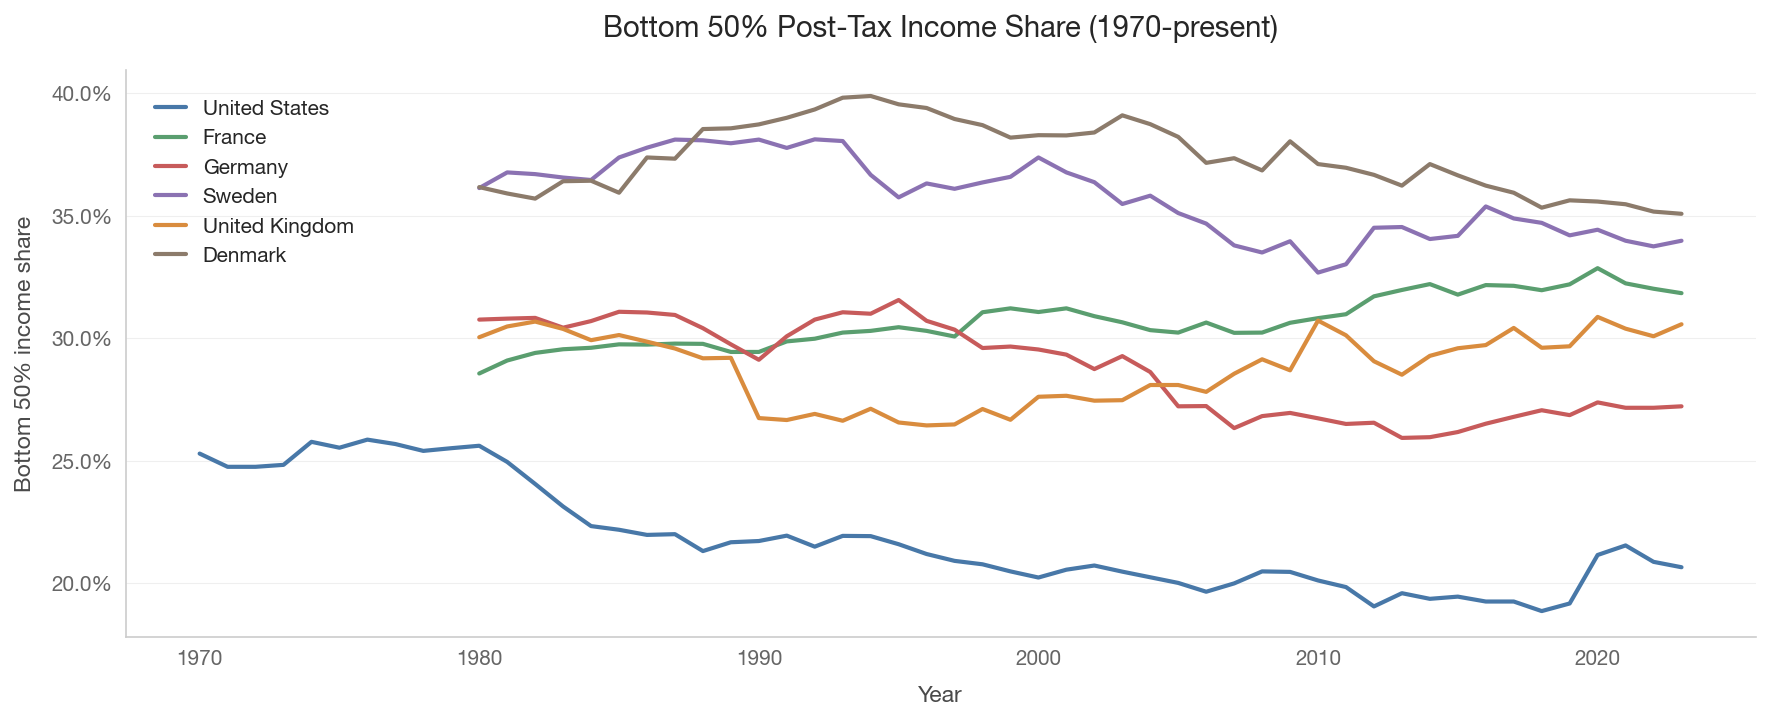

In [5]:
# Bottom 50% share: pre-tax vs post-tax
for concept, title_suffix in [('pretax', 'Pre-Tax'), ('posttax', 'Post-Tax')]:
    bottom50 = wid.get_top_shares_timeseries(
        ts_countries, percentile='p0p50', concept=concept, start_year=1970
    )
    
    if not bottom50.empty:
        fig, ax = plt.subplots(figsize=(12, 5))
        
        for cc in ts_countries:
            data = bottom50[bottom50['country'] == cc].sort_values('year')
            if not data.empty:
                ax.plot(data['year'], data['value'],
                        color=country_color(cc), linewidth=2,
                        label=country_name(cc))
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_xlabel('Year')
        ax.set_ylabel('Bottom 50% income share')
        ax.set_title(f'Bottom 50% {title_suffix} Income Share (1970-present)',
                     fontsize=14)
        ax.legend()
        
        plt.tight_layout()
        save_figure(fig, f'02_bottom50_{concept}_timeseries')
        plt.show()
    else:
        print(f"WID bottom 50% {concept} data not available.")

***
## 5. Decomposing the US-Europe Gap

How much of the US-Europe inequality gap is due to predistribution
(different market income distributions) vs. redistribution (different
tax-transfer systems)?

We compare the US to a European reference (France) at the pre-tax and
post-tax levels.


US vs France:
  Total disposable Gini gap: 9.100
  Due to predistribution (market income gap): 1.800 (20%)
  Due to redistribution (tax-transfer gap): 7.300 (80%)

US vs Germany:
  Total disposable Gini gap: 8.500
  Due to predistribution (market income gap): 0.300 (4%)
  Due to redistribution (tax-transfer gap): 8.200 (96%)

US vs Sweden:
  Total disposable Gini gap: 10.000
  Due to predistribution (market income gap): 3.600 (36%)
  Due to redistribution (tax-transfer gap): 6.400 (64%)


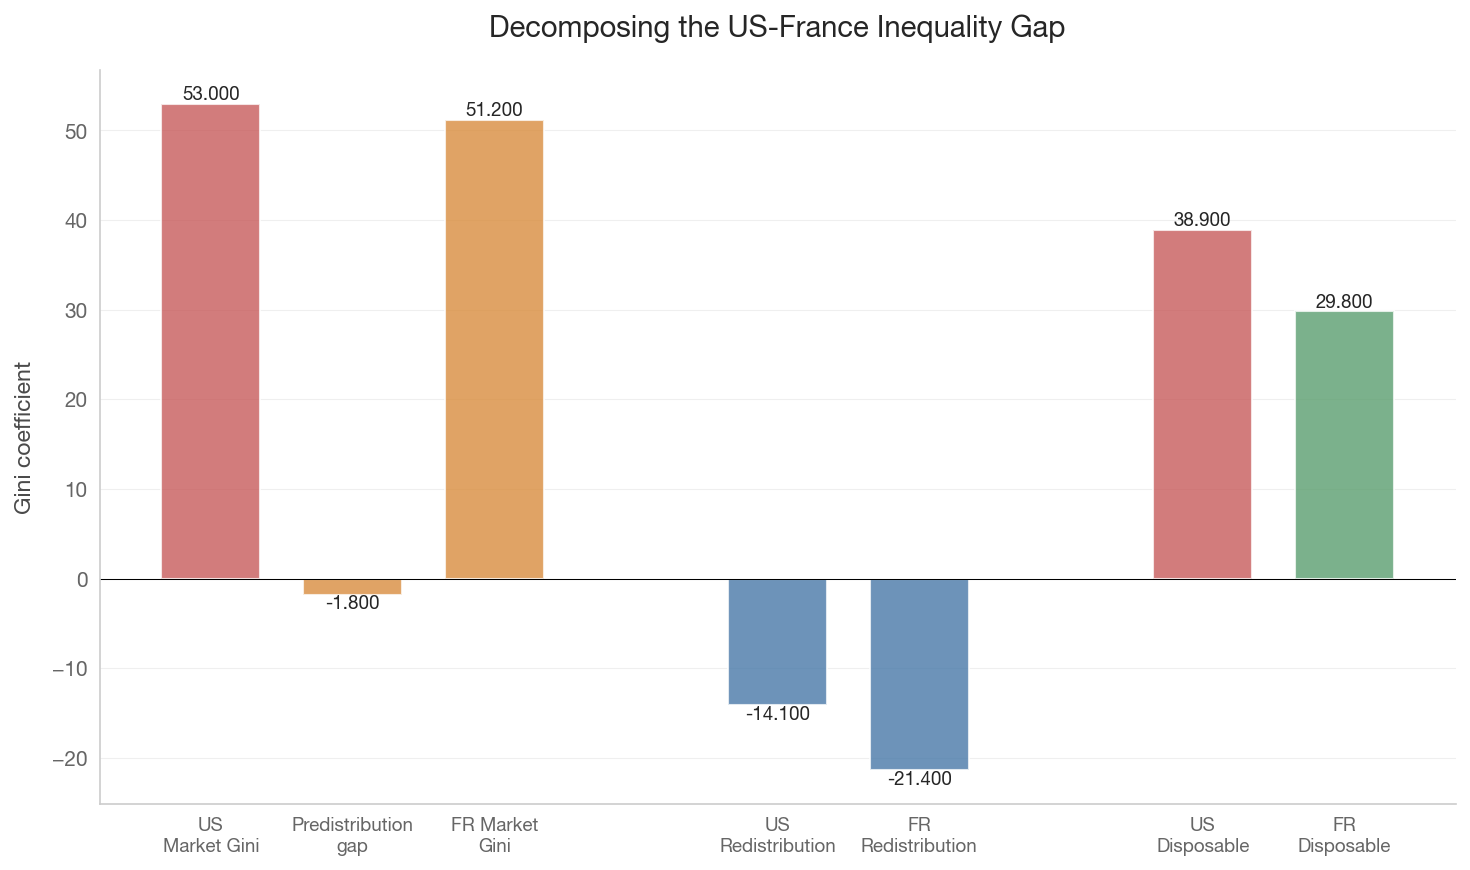

In [6]:
# Compare US vs France: pre-tax and post-tax Gini
decomp_countries = ['US', 'FR', 'DE', 'SE']
decomp = swiid.get_redistribution(decomp_countries,
                                    start_year=2017, end_year=2022)

if not decomp.empty:
    latest = (decomp.sort_values('year', ascending=False)
              .groupby('country_code').first().reset_index())
    latest = latest[latest['country_code'] != ''].set_index('country_code')
    
    if 'US' in latest.index:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        euro_countries = [c for c in decomp_countries if c != 'US' and c in latest.index]
        
        for ec in euro_countries:
            us_mkt = latest.loc['US', 'gini_mkt']
            us_disp = latest.loc['US', 'gini_disp']
            eu_mkt = latest.loc[ec, 'gini_mkt']
            eu_disp = latest.loc[ec, 'gini_disp']
            
            predist_gap = us_mkt - eu_mkt
            us_redist = us_mkt - us_disp
            eu_redist = eu_mkt - eu_disp
            redist_gap = eu_redist - us_redist
            total_gap = us_disp - eu_disp
            
            print(f"\nUS vs {country_name(ec)}:")
            print(f"  Total disposable Gini gap: {total_gap:.3f}")
            print(f"  Due to predistribution (market income gap): {predist_gap:.3f} "
                  f"({predist_gap/total_gap*100:.0f}%)" if total_gap > 0 else "")
            print(f"  Due to redistribution (tax-transfer gap): {redist_gap:.3f} "
                  f"({redist_gap/total_gap*100:.0f}%)" if total_gap > 0 else "")
        
        # Waterfall chart for US vs France
        if 'FR' in latest.index:
            us_mkt = latest.loc['US', 'gini_mkt']
            us_disp = latest.loc['US', 'gini_disp']
            fr_mkt = latest.loc['FR', 'gini_mkt']
            fr_disp = latest.loc['FR', 'gini_disp']
            
            categories = ['US\nMarket Gini', 'Predistribution\ngap',
                         'FR Market\nGini', 'US\nRedistribution',
                         'FR\nRedistribution',
                         'US\nDisposable', 'FR\nDisposable']
            values = [us_mkt, -(us_mkt - fr_mkt), fr_mkt,
                     -(us_mkt - us_disp), -(fr_mkt - fr_disp),
                     us_disp, fr_disp]
            
            x = [0, 1, 2, 4, 5, 7, 8]
            colors_bar = ['#c75b5b', '#d98c3e', '#d98c3e',
                         '#4878a8', '#4878a8',
                         '#c75b5b', '#5a9e6f']
            
            ax.bar(x, values, color=colors_bar, alpha=0.8, width=0.7)
            ax.set_xticks(x)
            ax.set_xticklabels(categories, fontsize=9)
            ax.set_ylabel('Gini coefficient')
            ax.set_title('Decomposing the US-France Inequality Gap', fontsize=14)
            ax.axhline(y=0, color='black', linewidth=0.5)
            
            # Add value labels
            for xi, vi in zip(x, values):
                ax.text(xi, vi + 0.01 * np.sign(vi), f'{vi:.3f}',
                        ha='center', va='bottom' if vi > 0 else 'top', fontsize=9)
            
            plt.tight_layout()
            save_figure(fig, '02_us_france_decomposition')
            plt.show()
else:
    print("SWIID redistribution data not available.")


***
## Key Takeaways

1. **Both predistribution and redistribution matter.** The US-Europe gap reflects
   differences in both market income distributions (predistribution) and in the
   aggressiveness of tax-transfer systems (redistribution).

2. **The US has higher pre-tax inequality AND less redistribution.** The gap is
   compounded: the US starts from a more unequal market distribution and then
   does less to compress it.

3. **The Blanchet et al. finding depends on definitions.** If you count social
   insurance as pre-tax income, predistribution dominates. If you count it as
   redistribution, the welfare state matters enormously. The empirical facts are
   not in dispute — the interpretive framework is.

4. **The pre-tax divergence since 1980 is striking.** US top income shares surged
   while European shares were relatively stable, suggesting that labor market
   institutions (unionization, wage bargaining, minimum wages) play a major role.